In [5]:
import math
import cmath
import numba
import numpy as np
from numba import cuda
from sigcom.tx.util import make_cells
from sigcom.ch.util import make_noise
from sigcom.tx.util import qam_alphabet

N_cells = 3240
M = 16

qam0 = qam_alphabet(M)
qam1 = qam_alphabet(M)
tx0, bits0 = make_cells(qam0, N_cells)
tx1, bits1 = make_cells(qam1, N_cells)
noise = make_noise(N_cells)
tx0 = np.asarray(tx0, np.complex64)
tx1 = np.asarray(tx1, np.complex64)
noise = np.asarray(noise, np.complex64)
phase = np.asarray(np.exp(1j*2*np.pi*np.random.rand(N_cells)), np.complex64)

In [6]:
def qam2str(qam):
    sqam = ','.join([str(q) for q in qam])
    return '[' + sqam + ']'

sqam0 = qam2str(qam0)
sqam1 = qam2str(qam1)

In [7]:
@cuda.jit(device=True)
def max_star(a,b):
    return max((a,b))+math.log(1.+math.exp(-abs(a-b)))

s='''
cqam0 = np.array({sqam0})
cqam1 = np.array({sqam1})

@cuda.jit
def _MI0(MIs, tx0, tx1, noise, h0, h1, C_Ns_dB, C_Is_dB, rho_dB):
    qam0 = cuda.const.array_like(cqam0)
    qam1 = cuda.const.array_like(cqam1)
    
    bidx = cuda.blockIdx.x
    bidy = cuda.blockIdx.y
    
    C_I = 10.**(C_Is_dB[bidy]/10.)
    C_N = 10.**(C_Ns_dB[bidx]/10.)
    rho = 10.**(rho_dB/10)

    Cp_sqrt  = math.sqrt(2.*rho/(1.+rho))
    Cpp_sqrt = math.sqrt(2./(1.+rho))
    Ip_sqrt  = math.sqrt(2./(1.+rho)/C_I)
    Ipp_sqrt = math.sqrt(2.*rho/(1.+rho)/C_I)
    
    P_noise = 1./C_N
    
    N_cells = len(tx0)
    MI0 = 0.
    for k in range(N_cells):
        if (k//(N_cells//2)) % 2 == 0:
            C_sqrt = Cp_sqrt
            I_sqrt = Ip_sqrt
        else:
            C_sqrt = Cpp_sqrt
            I_sqrt = Ipp_sqrt
        
        rx = C_sqrt*tx0[k]*h0[k] + I_sqrt*tx1[k]*h1[k] + noise[k]*math.sqrt(P_noise)
        
        num = -np.inf
        den = -np.inf
        for x1 in qam1:
            D = rx - C_sqrt*h0[k]*tx0[k] - I_sqrt*x1*h1[k]
            num = max_star(num, -abs(D)**2/P_noise)
            for x0 in qam0:
                D = rx - C_sqrt*x0*h0[k] - I_sqrt*x1*h1[k]
                den = max_star(den, -abs(D)**2/P_noise)
        MI0 += num - den
    MIs[bidy, bidx] = {ldM0} + MI0/N_cells/math.log(2.0)

'''.format(sqam0=sqam0, sqam1=sqam1, 
           M0=len(qam0), ldM0=int(np.log2(M)),
           M1=len(qam1), ldM1=int(np.log2(M)))
exec(s, globals())

In [8]:
C_Is_dB = np.linspace(-10,10,21)
C_Ns_dB = np.linspace(-10,10,21)
rho_dB = 0
h0 = np.ones(N_cells, dtype=np.complex64)
h1 = phase
MIs = np.zeros((len(C_Is_dB), len(C_Ns_dB)), dtype=np.float32)
_MI0[(len(C_Is_dB), len(C_Ns_dB)),1](MIs, tx0, tx1, noise, h0, h1, C_Ns_dB, C_Is_dB, rho_dB)

CudaAPIError: [702] Call to cuLinkCreate results in CUDA_ERROR_LAUNCH_TIMEOUT

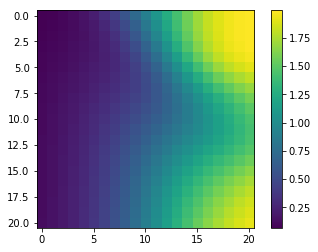

In [53]:
import matplotlib.pyplot as plt
plt.imshow(MIs)
plt.colorbar()
plt.show()